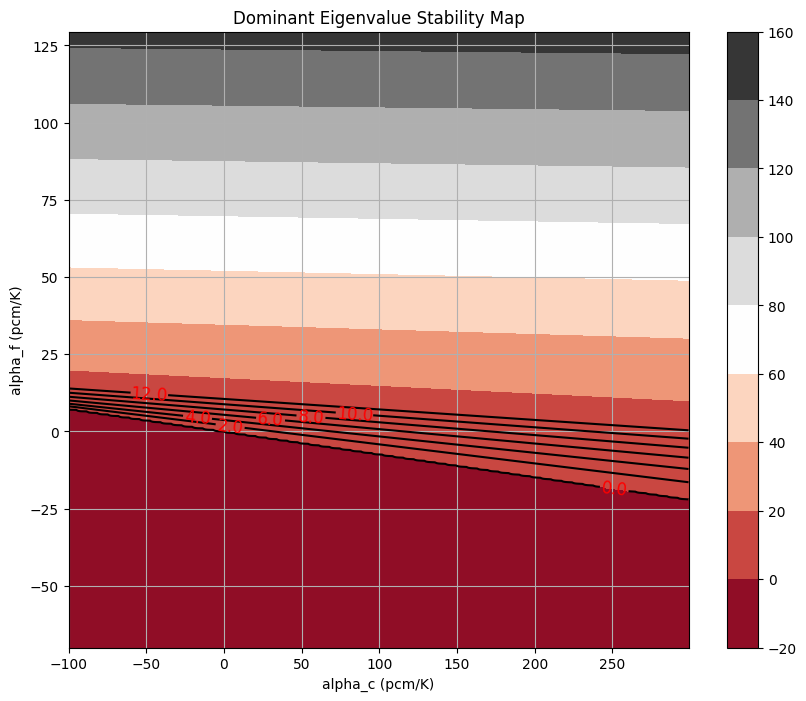

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from numpy.linalg import eig
import matplotlib.pyplot as plt

def build_A_matrix(alpha_f, alpha_c,
                   beta, beta_i, lam, Lambda,
                   tau_f=1.0, tau_c=1.0, tau_0=1.0,
                   P0_K_tau_f=0.0):
    """
    Builds and returns the A matrix for the 6-group + thermal-hydraulics
    linear model, given the sum of reactivity coefficients alpha_f, alpha_c,
    the delayed neutron data (beta, beta_i, lam[]), the prompt gen time Lambda,
    and example thermal-hydraulic time constants.

    Parameters
    ----------
    alpha_f : float
        Combined Doppler + axial expansion reactivity coefficient (dimensionless)
    alpha_c : float
        Combined coolant density + radial expansion reactivity coefficient (dimless)
    beta : float
        Total delayed neutron fraction (dimensionless)
    beta_i : list or array of floats
        Individual delayed neutron fractions for 6 groups (dimensionless)
    lam : list or array of floats
        Decay constants for 6 groups (1/s)
    Lambda : float
        Prompt neutron generation time (s)
    tau_f : float, optional
        Fuel time constant (s)
    tau_c : float, optional
        Coolant time constant (s)
    tau_0 : float, optional
        Additional coolant/loop time constant (s)
    P0_K_tau_f : float, optional
        Term for (P0 / (K * tau_f)) in the linearized fuel temperature equation

    Returns
    -------
    A : 2D numpy array of shape (9, 9)
        State matrix A
    """

    # Number of precursor groups
    n_dg = 6

    # Unpack the first 7 states for neutron + precursors
    # x = [ psi, eta1, eta2, eta3, eta4, eta5, eta6, Tf, Tc ]
    # We'll build row by row:

    A = np.zeros((9, 9))

    # 1) dpsi/dt row
    #   dpsi = [-(beta/Lambda)*psi + sum_{i=1..6}(beta_i/Lambda * eta_i)
    #           + (alpha_f/Lambda)*Tf + (alpha_c/Lambda)*Tc ]
    A[0, 0] = -(beta)/Lambda
    for i in range(n_dg):
        A[0, 1 + i] = beta_i[i]/Lambda
    A[0, 7] = alpha_f / Lambda  # Tf
    A[0, 8] = alpha_c / Lambda  # Tc

    # 2) Precursor rows: detai/dt = lam_i*psi - lam_i*eta_i
    for i in range(n_dg):
        A[1 + i, 0] = lam[i]       # + lam_i * psi
        A[1 + i, 1 + i] = -lam[i]  # - lam_i * eta_i

    # 3) Fuel temperature row (8th state => index 7)
    #   dTf = P0_K_tau_f
    #         - (1/tau_f)*Tf
    #         + (1/tau_f)*Tc
    A[7, 0] = P0_K_tau_f
    A[7, 7] = -1.0 / tau_f
    A[7, 8] =  1.0 / tau_f

    # 4) Coolant temperature row (9th state => index 8)
    #   dTc = (1/tau_c)*Tf
    #         - [2/tau_0 + 1/tau_c]*Tc
    A[8, 7] = 1.0 / tau_c
    A[8, 8] = - (2.0 / tau_0 + 1.0 / tau_c)

    return A

def is_stable(A):
    """
    Returns True if all eigenvalues of A have negative real parts
    (i.e., the system is asymptotically stable).
    """
    eigvals, _ = np.linalg.eig(A)
    # Stability: max real part < 0
    return np.max(eigvals.real) < 0

def max_real_eig(A):
    """
    Returns the maximum real part of the eigenvalues of matrix A.
    """
    eigvals, _ = np.linalg.eig(A)

    return np.max(eigvals.real)

def main():
    # ----------------------------------------------------------------------
    # 1. Define parameters for BoC (Beginning of Cycle)
    #    All reactivity feedback coefficients in [pcm/°C],
    #    then convert to dimensionless reactivity: 1 pcm = 1e-5 (dk/k)
    # ----------------------------------------------------------------------
    alpha_D_boc = -0.15    # pcm/°C
    alpha_C_boc = -1.2267  # pcm/°C
    alpha_A_boc = -0.0429  # pcm/°C
    alpha_R_boc = -0.7741  # pcm/°C


    # Delayed neutron data at BoC
    # Beta total, in pcm
    beta_boc_pcm = 319.0
    beta_boc = beta_boc_pcm * 1e-5  # dimensionless

    # Individual group fractions in pcm
    beta1_boc = 6.142
    beta2_boc = 71.40
    beta3_boc = 34.86
    beta4_boc = 114.1
    beta5_boc = 69.92
    beta6_boc = 22.68
    beta_i_boc = np.array([beta1_boc, beta2_boc, beta3_boc,
                           beta4_boc, beta5_boc, beta6_boc]) * 1e-5  # dimensionless

    # Decay constants at BoC (s^-1)
    lam_boc = np.array([0.0125, 0.0292, 0.0895, 0.2575, 0.6037, 2.6688])

    # Prompt neutron generation time (microseconds => seconds)
    Lambda_boc_us = 0.8066
    Lambda_boc = Lambda_boc_us * 1.0e-6  # s

    tau_f = 1.336  # s
    tau_c = 1.321   # s
    tau_0 = 0.210   # s

    P0_K_tau_f = 374.25
    # Points for mapping stability
    M = 400  # Number of steps for alpha_f
    N = 400  # Number of steps for alpha_c
    L_X = np.zeros(N)  # alpha_c values
    L_Y = np.zeros(M)  # alpha_f values
    Ma = np.zeros((M, N))  # Matrix to store dominant eigenvalues

    # Eigenvalue calculation loop
    for ALF in range(0, M):
      for ALC in range(0, N):
         alpha_f = (-70 + ALF / 2) / 100000  # Feedback coefficient alpha_f
         alpha_c = (-100 + ALC) / 100000    # Feedback coefficient alpha_c
         L_X[ALC] = -100 + ALC  # Store alpha_c values
         L_Y[ALF] = -70 + ALF / 2  # Store alpha_f values
         A_boc = build_A_matrix(alpha_f, alpha_c,
                           beta_boc, beta_i_boc, lam_boc, Lambda_boc,
                           tau_f, tau_c, tau_0, P0_K_tau_f)
         # Compute dominant eigenvalue
         P1 = np.linalg.eigvals(A_boc)

         h = np.max(np.real(P1))  # Dominant eigenvalue
         Ma[ALF, ALC] = h
         # Plotting Results

    plt.figure(figsize=(10, 8))
    levels = [-10.0, 0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0]
    contour = plt.contour(L_X, L_Y, Ma, levels, colors='black')
    plt.clabel(contour, colors='red', fmt='%2.1f', fontsize=12)
    contour_filled = plt.contourf(L_X, L_Y, Ma, cmap='RdGy')
    plt.colorbar(contour_filled)
    plt.title('Dominant Eigenvalue Stability Map')
    plt.xlabel('alpha_c (pcm/K)')
    plt.ylabel('alpha_f (pcm/K)')
    plt.grid()
    plt.show()




if __name__ == '__main__':
    main()